**Parkinson’s disease (PD) patients** 
- Subjects:
    - S1 - S10
    - S13 - S14
    - S16 - S21
- Total: 18
- Proportion: 54%
- Sessions: 8 - 11, except S16, 5

**Healthy controls**
- Subjects: 
    - S11 - S12
    - S15
    - S22 - S33 
- Total: 15
- Proportion: 45%
- Sessions: 8-11

In [ ]:
import pandas as pd 
import numpy as np
import os
from os import walk
import statistics
from matplotlib import pyplot as pt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mannwhitneyu
import math 
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from tqdm.notebook import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Read data
n_subjects = 33
press = []
release = []
pressure = []
ses = []
sub = []
i= -1
patient_session = []

for subject in list(range(1, n_subjects+1)):
    subjectID = str(subject).zfill(2)
    path_to_data = "/content/gdrive/MyDrive/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Data"+ "/S" + subjectID
    #path_to_data = "/Users/mariabaeza/Desktop/Universidad/BigData/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Data"+  "/S" + subjectID
    os.chdir(path_to_data)
    i+=1
    j = 0
    _, _, filenames = next(walk(path_to_data))
    for session in filenames:
        if session != ".DS_Store":
            j+=1
            with open(session) as f:
                lines = f.read().splitlines()
                for line in lines:
                    if line != "":
                        x = line.split(",")
                        y = x[2].split(" ")
                        press.append(int(x[1]))
                        release.append(int(y[1]))
                        pressure.append(float(x[3]))
                        ses.append(int(session.split("_")[1].split(".")[0].split("TEX")[1]))
                        sub.append(int(subject))
    patient_session.append(j)

In [ ]:
#Create dataframe
data = {'PressTime':  press,
        'ReleaseTime': release,
        'Pressure': pressure,
        'SessionID': ses,
        'SubjectID': sub
        }

df = pd.DataFrame (data, columns = ['PressTime','ReleaseTime','Pressure','SessionID','SubjectID'])

pd_patients = [1,2,3,4,5,6,7,8,9,10,13,14,16,17,18,19,20,21]
df['Class'] = np.zeros(len(df))
df["Class"]=df.SubjectID.apply(lambda x: x in pd_patients,1)
df.head()


In [ ]:
df['Time']= np.zeros(len(df))
for subject, session in df.groupby(["SubjectID","SessionID"]): 
    time_session = session.PressTime - session.PressTime.iloc[0]
    df.iloc[time_session.index,6] = time_session/1000
df.head()


,PressTime,ReleaseTime,Pressure,SessionID,SubjectID,Class,Time
0,17659554,17659619,0.6125,11,1,True,0.000
1,17660252,17660332,0.6750,11,1,True,0.698
2,17660866,17660948,0.6250,11,1,True,1.312
3,17661676,17661736,0.7000,11,1,True,2.122
4,17662864,17662942,0.6500,11,1,True,3.310


In [ ]:
#df.to_csv("/Users/mariabaeza/Desktop/Universidad/BigData/TFM/data.csv")

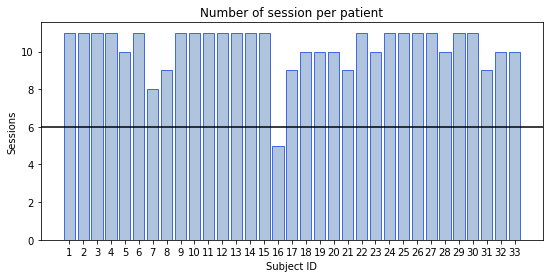

In [ ]:
aa = df.groupby(["SubjectID"]).size()
Subjects = [str(i) for i in range(1,34)]
plt.figure(figsize=(9, 4))
plt.bar(Subjects,patient_session, edgecolor="royalblue",color= 'lightsteelblue')
plt.xticks(rotation=0)
plt.xlabel("Subject ID")
plt.ylabel("Sessions")
plt.title("Number of session per patient")
plt.axhline(y = 6, color = "k")
plt.savefig('/content/gdrive/MyDrive/TFM/session_patient.eps', format='eps')

In [ ]:
session_size.to_csv("/content/gdrive/MyDrive/TFM/session_size.csv")

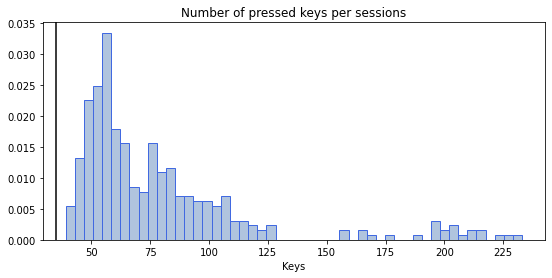

In [ ]:
session_size = df.groupby(["SubjectID","SessionID"]).size()
plt.figure(figsize=(9, 4))
plt.hist(session_size.values,density=True, bins=50,  edgecolor="royalblue",  color= 'lightsteelblue')
plt.xlabel("Keys")
plt.title("Number of pressed keys per sessions")
plt.axvline(x=35, color = "k")
#plt.savefig('/content/gdrive/MyDrive/TFM/key_session.eps', format='eps')

$HT_n = t_n^r - t_n^p, n=1,2,...,N$

$FT_n = t_{n-1}^p - t_n^r, n=1,2,..., N-1$

In [ ]:
#Number of keys for each subject and session
df.groupby(["SubjectID","SessionID"]).size()

SubjectID  SessionID
1          1            195
           2             49
           3             57
           4             47
           5             57
                       ... 
33         6             88
           7             67
           8             52
           9             95
           10            50
Length: 338, dtype: int64

In [ ]:
df_feat = pd.DataFrame()
df_feat['NP'] = df['Pressure']
df_feat["HT"] = df["ReleaseTime"] - df["PressTime"]
df_feat["FT"] = np.zeros(len(df))
df_feat["SessionID"] =  df['SessionID']
df_feat["SubjectID"] =  df['SubjectID']
for subject, session in df.groupby(["SubjectID","SessionID"]): 
    iterkey = session.iterrows()
    for index, row in iterkey:
        df_feat.iloc[index-1,2] = df.iloc[index ,0] - df.iloc[index - 1,1]
df_feat['Class'] = df.Class
df_feat['Time'] = df.Time
df_feat.head() 


,NP,HT,FT,SessionID,SubjectID,Class,Time
0,0.6125,65,633.0,11,1,True,0.000
1,0.6750,80,534.0,11,1,True,0.698
2,0.6250,82,728.0,11,1,True,1.312
3,0.7000,60,1128.0,11,1,True,2.122
4,0.6500,78,475.0,11,1,True,3.310


In [ ]:
df_feat = df_feat.drop(df_feat[(df_feat.SubjectID ==26) & (df_feat.SessionID == 11)].index)
df_feat = df_feat.drop(df_feat[(df_feat.SubjectID ==32) & (df_feat.SessionID == 5)].index)
df_feat = df_feat.drop(df_feat[(df_feat.SubjectID ==16)].index)

In [ ]:
class RawFeaturesCleaner:
  # We are setting the defaults to what we observed and recommended in the
  # exploration steps detailed in `02_loading_and_exploring.ipynb`
  UNWANTED_COLUMNS = ['date','timestamp','flight_time']
  HOLD_TIME_OUTLIER_THRESHOLD = 1000
  MINIMUM_OBSERVATIONS_PER_USER = 1000
  EXCLUDE_HIGH_IMPACT_CLASSES = ['Medium', 'Severe']
  EXCLUDE_USERS_TAKING = []
  
  def __init__(self, options={}):
    self.unwanted_columns = self.UNWANTED_COLUMNS
    self.hold_time_outlier_threshold = self.HOLD_TIME_OUTLIER_THRESHOLD
    self.minimum_observations_per_user = self.MINIMUM_OBSERVATIONS_PER_USER
    self.exclude_high_impact_classes = self.EXCLUDE_HIGH_IMPACT_CLASSES
    self.exclude_users_taking = self.EXCLUDE_USERS_TAKING
    
    if 'unwanted_columns' in options:
      self.unwanted_columns = options['unwanted_columns']
    if 'hold_time_outlier_threshold' in options:
      self.hold_time_outlier_threshold = options['hold_time_outlier_threshold']
    if 'minimum_observations_per_user' in options:
      self.minimum_observations_per_user = options['minimum_observations_per_user']
    if 'exclude_high_impact_classes' in options:
      self.exclude_high_impact_classes = options['exclude_high_impact_classes']
    if 'exclude_users_taking' in options:
      self.exclude_users_taking = options['exclude_users_taking']
  
  def discard_subject(self, df):
    indexes = df[df.SubjectID == 16].index
    df.drop(indexes, inplace=True)
    return self

  
  def discard_hold_time_outliers(self, df):
    indexes = df[df.HT > self.hold_time_outlier_threshold].index
    df.drop(indexes, inplace=True)
    return self
  

In [ ]:
cleaner = RawFeaturesCleaner()
# We don't want to deal with hold time higher than 1 second
cleaner.discard_hold_time_outliers(df_feat)

cleaner.discard_subject(df_feat)

# for the initial cleanup)
print(f'Number of users: {df_feat.SubjectID.nunique()}')
df.head()

Number of users: 32


,PressTime,ReleaseTime,Pressure,SessionID,SubjectID,Class,Time
0,17659554,17659619,0.6125,11,1,True,0.000
1,17660252,17660332,0.6750,11,1,True,0.698
2,17660866,17660948,0.6250,11,1,True,1.312
3,17661676,17661736,0.7000,11,1,True,2.122
4,17662864,17662942,0.6500,11,1,True,3.310


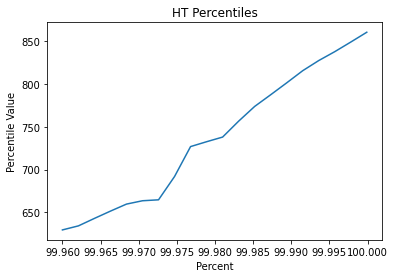

After the percentile 99.990 we see significantly higher values, which are definitely outliers.
Filtered out 3 rows with outliers in column 'HT'


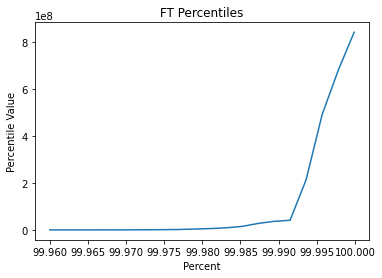

After the percentile 99.990 we see significantly higher values, which are definitely outliers.
Filtered out 3 rows with outliers in column 'FT'


In [ ]:
def filter_column_by_quantile(df, column, threshold):
    len_before = len(df)
    df = df[df[column] < np.percentile(df[column], threshold)]
    len_after = len(df)
    print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
    return df


def plot_percentiles_of_column(df, col, start, end, bins):
    X = np.linspace(start, end, bins)
    Y = [np.percentile(df[col], x) for x in X]
    plt.plot(X, Y)
    plt.title(col + " Percentiles")
    plt.xlabel("Percent")
    plt.ylabel("Percentile Value")
    plt.show()

    
# Filter out outliers of HoldTime:
plot_percentiles_of_column(df_feat, 'HT', 99.96, 99.9999, 20)
print("After the percentile 99.990 we see significantly higher values, which are definitely outliers.")
df_feat = filter_column_by_quantile(df_feat, 'HT', 99.990)

# Filter out outliers of Fligth:
plot_percentiles_of_column(df_feat, 'FT', 99.96, 99.9999, 20)
print("After the percentile 99.990 we see significantly higher values, which are definitely outliers.")
df_feat = filter_column_by_quantile(df_feat, 'FT', 99.990)

In [ ]:
df_nft.to_csv("/content/gdrive/MyDrive/TFM/df_nft.csv")

In [ ]:
#NFT Normalization (Iakovakis19)
df_nft = pd.DataFrame()
df_nft = df_feat

df_nft = df_nft.drop(df_nft[(df_nft['FT'] > 3000)].index) #more than 3 seconds 
df_nft['NFT']=(df_nft.FT-df_nft.groupby(["SubjectID","SessionID"]).FT.transform('mean'))#
df_nft = df_nft.drop(df_nft[((df_nft['NFT'] > 1700) | (df_nft['NFT'] < -1270))].index) #conditional filtering step. 
df_nft

,NP,HT,FT,SessionID,SubjectID,Class,Time,NFT
55,0.5875,71,842.0,3,1,True,0.000,-153.759259
56,0.5750,80,1268.0,3,1,True,0.913,272.240741
57,0.6250,78,558.0,3,1,True,2.261,-437.759259
58,0.6125,99,897.0,3,1,True,2.897,-98.759259
59,0.7125,115,1989.0,3,1,True,3.893,993.240741
...,...,...,...,...,...,...,...,...
26230,0.4375,74,116.0,6,33,False,33.219,1285.352273
26231,0.6500,82,259.0,6,33,False,33.409,1428.352273
26232,0.7500,49,318.0,6,33,False,33.750,1487.352273
26233,0.7000,64,151.0,6,33,False,34.117,1320.352273


In [ ]:
#df_feat.to_csv("/Users/mariabaeza/Desktop/Universidad/BigData/TFM/data_feat.csv")

10 most common values in 'HoldTime' and their count:

HT
65     362
74     384
91     385
115    398
124    414
98     427
82     448
99     448
107    467
90     479
Name: HT, dtype: int64


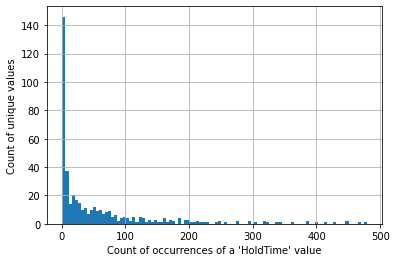

In [ ]:
holdTimeCounters = df_feat.groupby(['HT']).HT.count().sort_values()
print("10 most common values in 'HoldTime' and their count:\n")
print(holdTimeCounters.tail(10))
hist = holdTimeCounters.hist(bins=100).set(xlabel="Count of occurrences of a 'HoldTime' value", ylabel="Count of unique values")

SAVE PREPROCESSING

In [ ]:
import pickle
os.chdir("/content/gdrive/MyDrive/TFM")
#os.chdir("/Users/mariabaeza/Desktop/Universidad/BigData/TFM")
# Saving the objects:
with open('preprocessing.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([df_feat, df_nft, df, pd_patients], f)



In [ ]:
# Getting back the objects:
with open('preprocessing.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    df_feat, df_nft, df, pd_patients = pickle.load(f)